In [1]:
import requests
import pandas as pd
import numpy as np
import warnings
import datetime
warnings.filterwarnings('ignore')
# ============上市股票df============
url = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=1&issuetype=1&industry_code=&Page=1&chklike=Y"
response = requests.get(url)
listed = pd.read_html(response.text)[0]
listed.columns = listed.iloc[0,:]
listed = listed[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]
listed = listed.iloc[1:]

# ============上櫃股票df============
urlTWO = "https://isin.twse.com.tw/isin/class_main.jsp?owncode=&stockname=&isincode=&market=2&issuetype=&industry_code=&Page=1&chklike=Y"
response = requests.get(urlTWO)
listedTWO = pd.read_html(response.text)[0]
listedTWO.columns = listedTWO.iloc[0,:]
listedTWO = listedTWO.loc[listedTWO['有價證券別'] == '股票']
listedTWO = listedTWO[["有價證券代號","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]]

# ============上市股票代號+.TW============
stock_1 = listed["有價證券代號"]
stock_num = stock_1.apply(lambda x: str(x) + ".TW")
stock_num.loc[len(stock_num)+1] = '0050.TW'
stock_num.loc[len(stock_num)+1] = '^TWII'
# print(stock_num)

# ============上櫃股票代號+.TWO============
stock_2 = listedTWO["有價證券代號"]
stock_num2 = stock_2.apply(lambda x: str(x) + ".TWO")
# print(stock_num2)

# ============concate全部股票代號============
stock_num = pd.concat([stock_num, stock_num2], ignore_index=True)
# print(stock_num)
allstock_info = pd.concat([listed, listedTWO], ignore_index=True)
allstock_info.columns = ["ID","有價證券名稱","市場別","產業別","公開發行/上市(櫃)/發行日"]
allstock_info.set_index('ID', inplace = True)
print(allstock_info)


     有價證券名稱 市場別    產業別 公開發行/上市(櫃)/發行日
ID                                   
1101     台泥  上市   水泥工業     1962/02/09
1102     亞泥  上市   水泥工業     1962/06/08
1103     嘉泥  上市   水泥工業     1969/11/14
1104     環泥  上市   水泥工業     1971/02/01
1108     幸福  上市   水泥工業     1990/06/06
...     ...  ..    ...            ...
9949     琉園  上櫃  文化創意業     2003/11/21
9950    萬國通  上櫃   塑膠工業     2004/02/17
9951     皇田  上櫃   電機機械     2003/12/18
9960    邁達康  上櫃   運動休閒     2004/12/06
9962     有益  上櫃   鋼鐵工業     2006/07/10

[1855 rows x 4 columns]


## 全部策略選中股票

In [2]:
date = '2025-02-06'
filename = f'daily_stock_summary_{date}_with_template'
path = r'C:\Users\User\Desktop\stock\全個股條件篩選\\' + filename + '.xlsx'
# path = f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/全個股條件篩選/{date}.xlsx'
df = pd.read_excel(path)
# df = df.loc[df['business volume(億)'] > 3]
df['ID'] = df['ID'].apply(lambda x: str(x).split('.')[0])
df = df.set_index('ID')
df['市場別'] = None
df.drop(df[df['產業別']==0].index.values, inplace=True)
for i in df.index:
    df.loc[i, '市場別'] = allstock_info.loc[i, '市場別']
all_df = df.copy()
T5_id = all_df.loc[all_df['T5']].index.values
T5_2_id = all_df.loc[all_df['T5-2']].index.values 
T6_id = all_df.loc[all_df['T6']].index.values
T11_id = all_df.loc[all_df['T11']].index.values
T21_id = all_df.loc[all_df['T21']].index.values
TM = all_df.loc[all_df['TM']].index.values
T5_2_id = [i for i in T5_2_id if i not in T5_id]
T6_id = [i for i in T6_id if all([i not in T5_id, i not in T5_2_id])]
T11_id = [i for i in T11_id if all([i not in T5_id, i not in T5_2_id, i not in T6_id])]
T21_id = [i for i in T21_id if all([i not in T5_id, i not in T5_2_id, i not in T6_id, i not in T11_id])]
TM = [i for i in TM if all([i not in T5_id, i not in T5_2_id, i not in T6_id, i not in T11_id, i not in T21_id])]
template = ['T5', 'T5-2', 'T6', 'T11', 'T21', 'TM']
ids = [T5_id, T5_2_id, T6_id, T11_id, T21_id, TM]
all_text = ''
for i, t in enumerate(template):
    text = ''
    all_text += f'###{t}\n'
    for id in ids[i]:
        if df.loc[id, '市場別'] == '上櫃':
            text += f'TPEX:{id}\n'
        elif df.loc[id, '市場別'] == '上市':
            text += f'TWSE:{id}\n'
        # create and save to txt
    all_text += text
    
with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{date}_all.txt', 'w', encoding='utf-8') as f:
    f.write(all_text)
print(f'{date}_all.txt saved')


2025-02-06_all.txt saved


## 每日新增的股票

In [2]:
import pandas as pd
import numpy as np
# ============讀今日和昨日的股票Excel============

# path = r'C:\Users\User\Desktop\stock\全個股條件篩選\\' + filename + '.xlsx'
new_date = '2025-02-07'
new_filename = f'daily_stock_summary_{new_date}_with_template'
new_path = r'C:\Users\User\Desktop\stock\全個股條件篩選\\' + new_filename + '.xlsx'
old_date = '2025-02-06'
old_filename = f'daily_stock_summary_{old_date}_with_template' 
old_path = r'C:\Users\User\Desktop\stock\全個股條件篩選\\' + old_filename + '.xlsx'
df_new = pd.read_excel(new_path)
df_old = pd.read_excel(old_path)
df_new['ID'] = df_new['ID'].apply(lambda x: str(x).split('.')[0])
df_old['ID'] = df_old['ID'].apply(lambda x: str(x).split('.')[0])
df_new = df_new.set_index('ID')
df_old = df_old.set_index('ID')
df_new.drop(df_new[df_new['產業別']==0].index.values, inplace=True)
df_old.drop(df_old[df_old['產業別']==0].index.values, inplace=True)
df_new['市場別'] = None
df_old['市場別'] = None

# ============今日和昨日股票的ID============
df_same_ID = df_new.loc[df_new.index.isin(df_old.index.values)].index.values
df_old = df_old.loc[df_same_ID]
df_new = df_new.loc[df_same_ID]
old_T5_ID = df_old.loc[df_old['T5']].index.values
old_T5_2_ID = df_old.loc[df_old['T5-2']].index.values
old_T6_ID = df_old.loc[df_old['T6']].index.values
old_T11_ID = df_old.loc[df_old['T11']].index.values
new_T5_ID = df_new.loc[df_new['T5']].index.values
new_T5_2_ID = df_new.loc[df_new['T5-2']].index.values
new_T6_ID = df_new.loc[df_new['T6']].index.values
new_T11_ID = df_new.loc[df_new['T11']].index.values
new_T21_ID = df_new.loc[df_new['T21']].index.values
old_T21_ID = df_old.loc[df_old['T21']].index.values

# ============新增和刪除股票的ID============
T5_add_ID = np.sort([i for i in new_T5_ID if i not in old_T5_ID])
T5_drop_ID = np.sort([i for i in old_T5_ID if i not in new_T5_ID])
T6_add_ID = np.sort([i for i in new_T6_ID if i not in old_T6_ID])
T6_drop_ID = np.sort([i for i in old_T6_ID if i not in new_T6_ID])
T11_add_ID = np.sort([i for i in new_T11_ID if i not in old_T11_ID])
T11_drop_ID = np.sort([i for i in old_T11_ID if i not in new_T11_ID])
T5_2_add_ID = np.sort([i for i in new_T5_2_ID if i not in old_T5_2_ID])
T5_2_drop_ID = np.sort([i for i in old_T5_2_ID if i not in new_T5_2_ID])
T21_add_ID = np.sort([i for i in new_T21_ID if i not in old_T21_ID])
T21_drop_ID = np.sort([i for i in old_T21_ID if i not in new_T21_ID])
# T5_drop_goodID = np.sort([i for i in T5_drop_ID if all([df_new.loc[i,'S250rate']>=75, df_new.loc[i, 'S20rate']>85])])
# T5_2_drop_goodID = np.sort([i for i in T5_2_drop_ID if all([df_new.loc[i,'ES250rate']>=75, df_new.loc[i, 'ES20rate']>85])])
T5_2_add_ID = [i for i in T5_2_add_ID if i not in T5_add_ID]
T6_add_ID = [i for i in T6_add_ID if all([i not in T5_add_ID, i not in T5_2_add_ID])]
T11_add_ID = [i for i in T11_add_ID if all([i not in T5_add_ID, i not in T5_2_add_ID, i not in T6_add_ID])]
T21_add_ID = [i for i in T21_add_ID if all([i not in T5_add_ID, i not in T5_2_add_ID, i not in T6_add_ID, i not in T11_add_ID])]

template = ['T5', 'T5-2', 'T6', 'T11', 'T21']
add = [T5_add_ID, T5_2_add_ID, T6_add_ID, T11_add_ID, T21_add_ID]
all_txt = ''
for i, t in enumerate(template):
    all_txt += f'###{t}\n'
    text = ''
    for id in add[i]:
        id = str(id)
        if allstock_info.loc[id, '市場別'] == '上櫃':
            text += f'TPEX:{id}\n'
        elif allstock_info.loc[id, '市場別'] == '上市':
            text += f'TWSE:{id}\n'
        # create and save to txt
    all_txt += text
with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{new_date}_all_add.txt', 'w', encoding='utf-8') as f:
    f.write(all_txt)
print(f'{new_date}-all_add.txt saved')

2025-02-07-all_add.txt saved


## 特殊條件篩選 匯入tradingview

### Rebound Elite

In [13]:
import pandas as pd
D = '2025-02-14'
path = fr'C:\Users\User\Desktop\stock\全個股條件篩選\daily_stock_summary_{D}_with_template.xlsx'
df_origin = pd.read_excel(path)
bias_range = 3
df_RS98 = df_origin.loc[df_origin['RS_rate_250'] > 95]
df_RS98 = df_RS98.loc[df_RS98['business volume(億)'] > 5]
df = df_origin.loc[df_origin['ERS_rate_20'] > 80]
df = df.loc[df['ERS_rate_50'] > 80]
df = df.loc[df['ERS_rate_250'] > 80]
# df = df.loc[df['year high sort'] == True]
df = df.loc[df['year low sort'] == True]
df = df.loc[df['Volume 50MA>250k'] == True]
df = df.loc[df['business volume(億)'] > 3]
# df = df.loc[df['STD_7'] < df['STD_7_7MA']]
# df['5MA_bias'] = abs(df['Adj Close'] / df['5MA'] - 1)*100
# df['10MA_bias'] = abs(df['Adj Close'] / df['10MA'] - 1)*100
# df['20MA_bias'] = abs(df['Adj Close'] / df['20MA'] - 1)*100
# df['bigger_than_20MA'] = df['Adj Close']*0.97 > df['20MA']
# df = df.loc[df['5MA_bias'] < bias_range]
# df = df.loc[df['10MA_bias'] < bias_range]
# df = df.loc[df['20MA_bias'] < 10]
# df = df.loc[df['bigger_than_20MA'] == True]
sort_ID_RE = list(map(lambda x:x.split('.')[0],df['ID'].values))
sort_ID_RS98 = list(map(lambda x:x.split('.')[0],df_RS98['ID'].values))
print(len(sort_ID_RE), len(sort_ID_RS98))
# print(sort_ID)

label_name = ['Rebound Elite', 'RS95']
for name, sort_ID in zip(label_name, [sort_ID_RE, sort_ID_RS98]):
    text = ''
    text += f'###{name}\n'
    for id in sort_ID:
        id = str(id)
        if allstock_info.loc[id, '市場別'] == '上櫃':
            text += f'TPEX:{id}\n'
        elif allstock_info.loc[id, '市場別'] == '上市':
            text += f'TWSE:{id}\n'
    with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{D}_{name}.txt', 'w', encoding='utf-8') as f:
        f.write(text)
        print(f'{D}_{name}.txt.txt saved')
    # create and save to txt
# print(len(sort_ID))




54 27
2025-02-14_Rebound Elite.txt.txt saved
2025-02-14_RS95.txt.txt saved


#### 看個股是否符合RE策略

In [14]:
watch_IDs = '1307 2027 2543 6585 9802 2332 3558 3596 6526 2049 2374 3019 4571 4576 6215 2468 3029 5203 6763 2395 3088 6245 5269 1815 6191 3264 6290'.split(' ')
# path = fr'C:\Users\User\Desktop\stock\全個股條件篩選\daily_stock_summary_{D}_with_template.xlsx'
# df_origin = pd.read_excel(path)
df_watch = df_origin.copy()
df_watch['ID'] = df_watch['ID'].apply(lambda x: str(x).split('.')[0])
df_watch.set_index('ID', inplace=True)
watch_info = ['ERS_rate_20', 'ERS_rate_50', 'ERS_rate_250', 'year high sort', 'year low sort', 'Volume 50MA>250k', 'business volume(億)']

for watch_ID in watch_IDs:
    print(f'ID : {watch_ID}')
    for info in watch_info:
        if info in ['ERS_rate_20', 'ERS_rate_50', 'ERS_rate_250', 'business volume(億)']:
            print(f'{info} : {df_watch.loc[watch_ID, info]:.2f}')
        else:
            print(f'{info} : {df_watch.loc[watch_ID, info]}')


ID : 1307
ERS_rate_20 : 96.06
ERS_rate_50 : 95.62
ERS_rate_250 : 94.51
year high sort : True
year low sort : True
Volume 50MA>250k : True
business volume(億) : 1.15
ID : 2027
ERS_rate_20 : 98.56
ERS_rate_50 : 98.45
ERS_rate_250 : 91.18
year high sort : True
year low sort : True
Volume 50MA>250k : True
business volume(億) : 26.87
ID : 2543
ERS_rate_20 : 99.61
ERS_rate_50 : 99.50
ERS_rate_250 : 99.61
year high sort : True
year low sort : True
Volume 50MA>250k : True
business volume(億) : 41.18
ID : 6585
ERS_rate_20 : 92.34
ERS_rate_50 : 96.50
ERS_rate_250 : 91.29
year high sort : False
year low sort : True
Volume 50MA>250k : True
business volume(億) : 1.05
ID : 9802
ERS_rate_20 : 49.17
ERS_rate_50 : 88.35
ERS_rate_250 : 81.47
year high sort : True
year low sort : True
Volume 50MA>250k : True
business volume(億) : 1.54
ID : 2332
ERS_rate_20 : 64.93
ERS_rate_50 : 85.52
ERS_rate_250 : 89.35
year high sort : True
year low sort : True
Volume 50MA>250k : True
business volume(億) : 2.93
ID : 3558
ERS

#### 看RE策略選股的族群

In [12]:
#看個股產業
import pandas as pd
import requests
import IPython.display as ipd
d = '2025-01-20'
industry_df = pd.read_excel(r'C:\Users\User\Desktop\stock\others\產業別.xlsx').astype(int).astype(str)
group_df = pd.read_excel(r'C:\Users\User\Desktop\stock\others\族群_複製.xlsx').astype(int).astype(str)
concept_df = pd.read_excel(r'C:\Users\User\Desktop\stock\others\概念股_複製.xlsx').astype(int).astype(str)
rschoose_df = pd.read_excel(fr'C:\Users\User\Desktop\stock\全個股條件篩選\daily_stock_summary_{d}_with_template.xlsx')

alist = []
industry_category_df = []
show = True
CF_df = rschoose_df.sort_values(by='business volume(億)', ascending=False)
CF_df['ID'] = CF_df['ID'].apply(lambda x: str(x).split('.')[0])
CF_df = CF_df.reset_index(drop=True)
CF_df['CF'] = [round(100-(i/14), 1) for i in CF_df.index.values]
# to_watch = sort_ID #sort_ID, watch_IDs
to_watch = '6763'.split(' ')

for id in to_watch:
    stock_ind = []
    stock_ind.append(CF_df.loc[CF_df['ID'].astype(str) == id, 'ERS_rate_250'].values[0])
    stock_ind.append(CF_df.loc[CF_df['ID'].astype(str) == id, 'CF'].values[0])
    for col in industry_df.columns.values:
        if id in industry_df[col].values:
            stock_ind.append(col)
    for col in group_df.columns.values:
        if id in group_df[col].values:
            stock_ind.append(col)
    for col in concept_df.columns.values:
        if id in concept_df[col].values:
            stock_ind.append(col)
    alist.append((id,stock_ind))

for ind in alist:
    if show:
        print(ind[0], f'| RS({ind[1][0]}) | CF({ind[1][1]})', '-->', end=' ')
    for i in set(ind[1][2:]):
        if show:
            print(i, end=' ')
        industry_category_df.append([ind[0], i])
    print('')
industry_category_df = pd.DataFrame(industry_category_df,columns=['ID', 'category'])
industry_category_df['count'] = 1
industry_category_df = industry_category_df.groupby('category').sum()
count_df = industry_category_df.sort_values(by='count', ascending=False)
ipd.display(count_df.iloc[:30])

6763 | RS(90.35674470457079) | CF(73.1) --> 軟體業 軟體_系統整合 


,count
category,
軟體_系統整合,1
軟體業,1


#### 股票代號轉Tradingview 格式

In [ ]:
import pandas as pd
IDs = '6922 2395'.split(' ')
#2345 5388 6285 3596 
#4979 3450 3081 6442 3363
#3558 3029
#6922 2395
#2049 6215 4576
#3661 3443
#6922 2395
text = ''
D = '2025-02-14'
path = fr'C:\Users\User\Desktop\stock\全個股條件篩選\daily_stock_summary_{D}_with_template.xlsx'
df_origin = pd.read_excel(path)
df_origin['ID'] = df_origin['ID'].apply(lambda x: str(x).split('.')[0])
df = df_origin.loc[df_origin['ID'].isin(IDs)]
df.set_index('ID', inplace=True)
print(df.head())
for ID in IDs:
    ID = str(ID)
    MA20 = df.loc[ID, '20MA']
    if allstock_info.loc[ID, '市場別'] == '上櫃':
        text += f'TPEX:{ID}/{MA20}'
    elif allstock_info.loc[ID, '市場別'] == '上市':
        text += f'TWSE:{ID}/{MA20}'
    text += '+'
print(text[:-1])
# with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{D}_{name}.txt', 'w', encoding='utf-8') as f:
#     f.write(text)
#     print(f'{D}_{name}.txt.txt saved')
    # create and save to txt
# print(len(sort_ID))

       Open   High    Low  Close  Adj Close   Volume    5MA    10MA   20MA  \
ID                                                                           
6922  212.0  216.0  207.5  212.0      212.0   443707  221.8  216.95  204.8   
2395  403.0  403.0  395.5  400.0      400.0  2273629  405.6  401.20  382.2   

        50MA  ...  RS 250EMA 50MIN > 50  RS 250EMA 50MIN > 30  \
ID            ...                                               
6922  187.67  ...                  True                  True   
2395  363.99  ...                 False                  True   

      RS 50EMA 20MIN >30  RS 50EMA 20MIN >65     T5   T5-2     T6    T11  \
ID                                                                         
6922                True                True  False  False   True  False   
2395                True                True  False  False  False  False   

        T21     TM  
ID                  
6922   True  False  
2395  False   True  

[2 rows x 208 columns]
TPEX:6922/204

### 強弱勢指數

In [2]:
SS_dict = {'Date':[], 'SS':[], 'all_df':[]}

In [3]:
import pandas as pd
first_day = '2023-10-15' #2024-03-06
last_day = '2024-12-20'

# df = df_origin.loc[df_origin['ERS_rate_20'] > 80]
# df = df.loc[df['ERS_rate_250'] > 80]
# df = df.loc[df['year high sort'] == True]
# df = df.loc[df['year low sort'] == True]
# df = df.loc[df['Volume 50MA>250k'] == True]

for D in pd.date_range(first_day, last_day):
    D = str(D).split(' ')[0]
    try:
        path = fr'C:\Users\User\Desktop\stock\全個股條件篩選\daily_stock_summary_{D}_with_template.xlsx'
        df_origin = pd.read_excel(path)
    except:
        continue
    df = df_origin.loc[df_origin['business volume(億)'] > 1]
    df = df.loc[df['ERS_rate_20'] > 80]
    df = df.sort_values(by='ERS_rate_250', ascending=False)
    df = df.head(round((df.shape[0])*0.1))
    SS_dict['Date'].append(D)
    SS_dict['SS'].append(df)
    SS_dict['all_df'].append(df_origin)


# sort_ID = list(map(lambda x:x.split('.')[0],df['ID'].values))
# print(sort_ID)
# print(len(sort_ID))
# text = ''
# for id in sort_ID:
#     id = str(id)
#     if allstock_info.loc[id, '市場別'] == '上櫃':
#         text += f'TPEX:{id}\n'
#     elif allstock_info.loc[id, '市場別'] == '上市':
#         text += f'TWSE:{id}\n'
#     # create and save to txt
# print(len(sort_ID))
# with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{D}_SS.txt', 'w', encoding='utf-8') as f:
#     f.write(text)
# print(f'{D}_SS.txt saved')


In [6]:
len_df= pd.DataFrame([], columns=['len_id', 'Date'])
len_id = []
Date = []
avg_rocp = []
N = 3
expect_profit_list = []
win_rate_list = []
for i in range(len(SS_dict['Date'])-N):
    D = SS_dict['Date'][i+N]
    df_D = SS_dict['all_df'][i+N]
    stock_ids = []
    
    df_D = df_D.loc[df_D['ERS_rate_250'] > 90]
    df_D = df_D.loc[df_D['business volume(億)'] > 1]
    win_times = df_D.loc[df_D['ROCP'] > 0].shape[0]
    print(win_times, "/", df_D.shape[0], D, end=' ')
    try:
        win_rate = round(win_times / df_D.shape[0], 3)
    except:
        win_rate = 0
    win_profit = round(df_D.loc[df_D['ROCP'] > 0]['ROCP'].mean(), 3)
    loss_profit = round(df_D.loc[df_D['ROCP'] < 0]['ROCP'].mean(), 3)
    
    expect_profit = win_rate * win_profit + (1-win_rate) * loss_profit
    expect_profit_list.append(expect_profit)

    print(win_rate, win_profit, loss_profit, expect_profit)
    win_rate_list.append(win_rate)
    for j in range(N):
        D2 = SS_dict['Date'][i+N-j-1]
        df = SS_dict['SS'][i+N-j-1]
        stock_ids += df['ID'].values.tolist()
        # print(set(stock_ids))
    len_id.append(len(set(stock_ids)))
    Date.append(D)
    avg_rocp.append(df_D.loc[df_D['ID'].isin(stock_ids)]['ROCP'].mean())
    # print(len(set(stock_ids)), D)
len_df['len_id'] = len_id
len_df['Date'] = Date
# len_df.to_excel(r'C:\Users\User\Desktop\投資檢討\SS.xlsx', index=False)

    


57 / 99 2023-10-19 0.576 3.598 -2.186 1.1455839999999995
35 / 101 2023-10-20 0.347 3.4 -2.257 -0.2940210000000001
45 / 96 2023-10-23 0.469 3.428 -2.718 0.1644739999999998
84 / 101 2023-10-24 0.832 4.071 -2.315 2.9981519999999993
63 / 108 2023-10-25 0.583 3.784 -1.786 1.4613099999999997
18 / 103 2023-10-26 0.175 4.327 -3.182 -1.8679249999999996
50 / 104 2023-10-27 0.481 3.416 -2.219 0.49143499999999984
61 / 104 2023-10-30 0.587 3.221 -1.927 1.094876
20 / 110 2023-10-31 0.182 3.14 -4.301 -2.9467380000000007
63 / 95 2023-11-01 0.663 2.528 -1.361 1.2174070000000001
90 / 101 2023-11-02 0.891 4.242 -1.806 3.582768
56 / 100 2023-11-03 0.56 3.212 -2.354 0.7629600000000003
85 / 105 2023-11-06 0.81 3.973 -1.537 2.9261
64 / 107 2023-11-07 0.598 2.918 -1.622 1.09292
64 / 101 2023-11-08 0.634 3.111 -2.063 1.217316
39 / 107 2023-11-09 0.364 3.389 -2.768 -0.5268519999999999
39 / 104 2023-11-10 0.375 2.569 -2.45 -0.567875
84 / 118 2023-11-13 0.712 3.829 -2.41 2.032168
89 / 119 2023-11-14 0.748 2.875 -

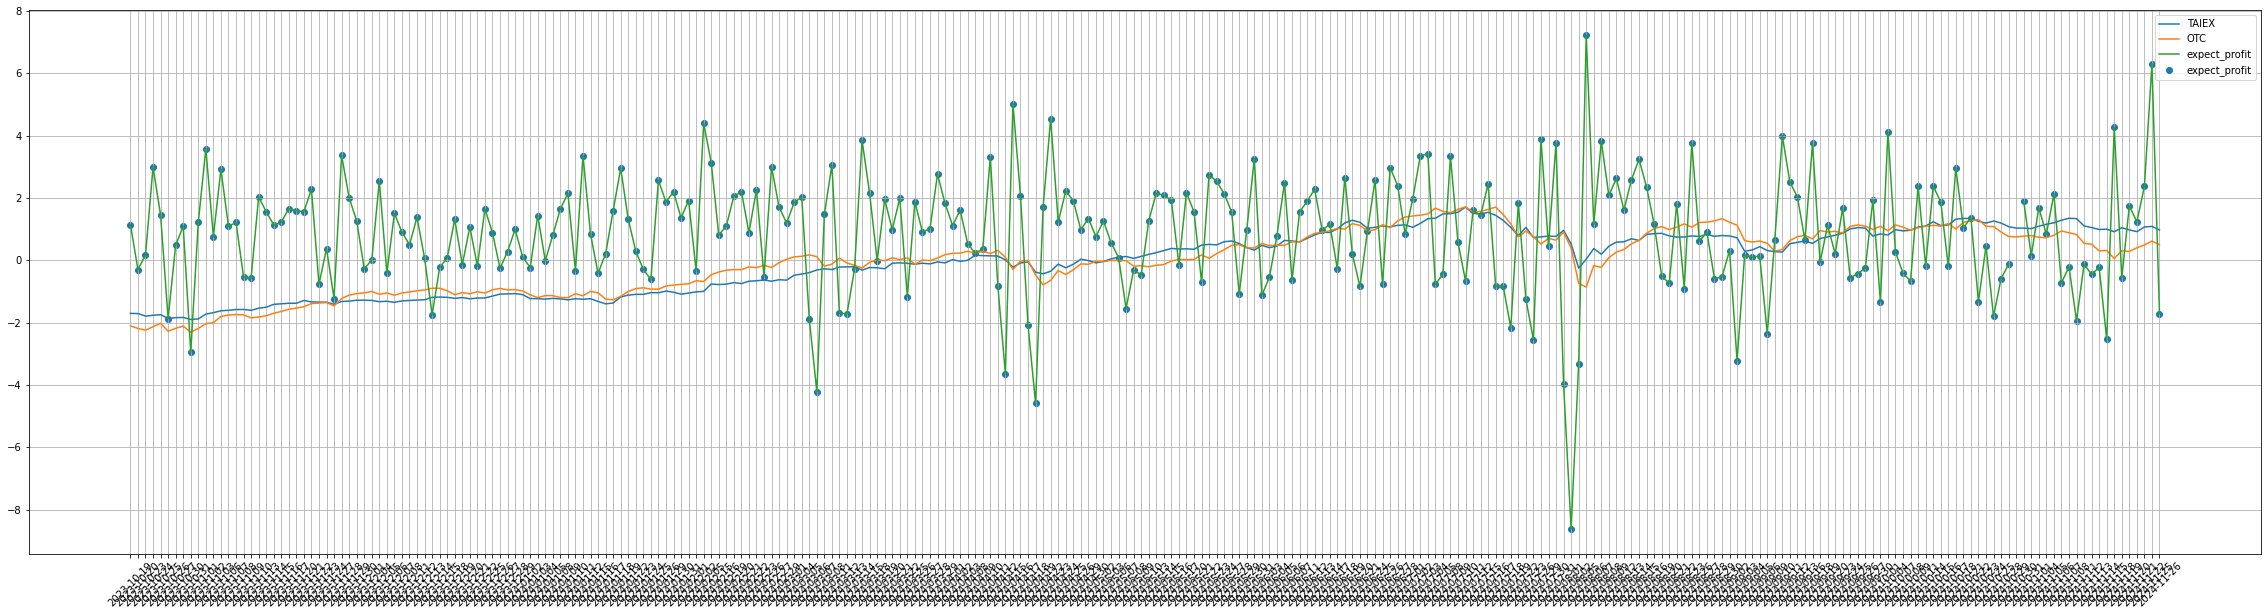

['2023-10-19' '2023-10-20' '2023-10-23' '2023-10-24' '2023-10-25'
 '2023-10-26' '2023-10-27' '2023-10-30' '2023-10-31' '2023-11-01'
 '2023-11-02' '2023-11-03' '2023-11-06' '2023-11-07' '2023-11-08'
 '2023-11-09' '2023-11-10' '2023-11-13' '2023-11-14' '2023-11-15'
 '2023-11-16' '2023-11-17' '2023-11-20' '2023-11-21' '2023-11-22'
 '2023-11-23' '2023-11-24' '2023-11-27' '2023-11-28' '2023-11-29'
 '2023-11-30' '2023-12-01' '2023-12-04' '2023-12-05' '2023-12-06'
 '2023-12-07' '2023-12-08' '2023-12-11' '2023-12-12' '2023-12-13'
 '2023-12-14' '2023-12-15' '2023-12-18' '2023-12-19' '2023-12-20'
 '2023-12-21' '2023-12-22' '2023-12-25' '2023-12-26' '2023-12-27'
 '2023-12-28' '2023-12-29' '2024-01-02' '2024-01-03' '2024-01-04'
 '2024-01-05' '2024-01-08' '2024-01-09' '2024-01-10' '2024-01-11'
 '2024-01-12' '2024-01-15' '2024-01-16' '2024-01-17' '2024-01-18'
 '2024-01-19' '2024-01-22' '2024-01-23' '2024-01-24' '2024-01-25'
 '2024-01-26' '2024-01-29' '2024-01-30' '2024-01-31' '2024-02-01'
 '2024-02-

In [27]:
import numpy as np
df = pd.read_excel(f'C:/Users/User/Desktop/stock/100產業分析/每日策略選股數量.xlsx')
TAIEX = pd.read_csv(r'C:\Users\User\Desktop\stock\data_test\^TWII.csv', header=0)
OTC = pd.read_csv(r'C:\Users\User\Desktop\stock\data_test\IX0043.csv', header=0)
TAIEX = TAIEX.loc[TAIEX['Date'] >= '2023-10-19']
TAIEX = TAIEX.loc[TAIEX['Date'] <= '2024-11-26']
OTC = OTC.loc[OTC['Date'] >= '2023-10-19']
OTC = OTC.loc[OTC['Date'] <= '2024-11-26']
X = TAIEX['Date'].values
norm_TAIEX_adjclose = (TAIEX['Adj Close'] - TAIEX['Adj Close'].mean()) / TAIEX['Adj Close'].std()
Y = norm_TAIEX_adjclose.values
X2 = OTC['Date'].values
norm_OTC_adjclose = (OTC['Adj Close'] - OTC['Adj Close'].mean()) / OTC['Adj Close'].std()
Y2 = norm_OTC_adjclose.values
norm_len_id = (len_df['len_id'] - len_df['len_id'].mean()) / len_df['len_id'].std()

sum_avg_rocp = []
for i in range(len(avg_rocp)):
    sum_avg_rocp.append(sum(avg_rocp[:i+1]))


norm_sum_avg_rocp = (sum_avg_rocp - np.mean(sum_avg_rocp)) / np.std(sum_avg_rocp)
norm_win_rate = (win_rate_list - np.mean(win_rate_list)) / np.std(win_rate_list)

expect_profit_5MA = [0, 0, 0, 0, 0]
expect_profit_10MA = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
expect_profit_20MA = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
for i in range(5, len(expect_profit_list)):
    expect_profit_5MA.append(np.mean(expect_profit_list[i-5:i]))
for i in range(20, len(expect_profit_list)):
    expect_profit_20MA.append(np.mean(expect_profit_list[i-20:i]))
for i in range(10, len(expect_profit_list)):
    expect_profit_10MA.append(np.mean(expect_profit_list[i-10:i]))


# norm_expect_profit = (expect_profit_list - np.min(expect_profit_list)) / (np.max(expect_profit_list) - np.min(expect_profit_list))
# print(norm_expect_profit)
import matplotlib.pyplot as plt
plt.figure(figsize=(40, 10))
plt.plot(X, Y, label='TAIEX')
plt.plot(X2, Y2, label='OTC')
# plt.plot(norm_win_rate, label='win_rate')
# plt.plot(expect_profit_5MA, label='expect_profit')

plt.plot(X, expect_profit_list[:len(X)], label='expect_profit')
plt.scatter(X, expect_profit_list[:len(X)], label='expect_profit')


# plt.plot(X, expect_profit_5MA[:len(X)], label='expect_profit_5MA')
# plt.scatter(X, expect_profit_5MA[:len(X)], label='expect_profit_5MA')

# plt.plot(X, expect_profit_10MA[:len(X)], label='expect_profit_10MA')
# plt.scatter(X, expect_profit_10MA[:len(X)], label='expect_profit_10MA')

# plt.plot(expect_profit_20MA, label='expect_profit_20MA')
# plt.scatter(X, expect_profit_20MA[:len(X)], label='expect_profit_20MA')

# plt.plot(norm_len_id, label='len_id')
# plt.plot(norm_sum_avg_rocp, label='sum_avg_rocp')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()
print(X2)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib


df_profit = pd.read_excel(r'C:\Users\User\Desktop\投資檢討\投資日記.xlsx', sheet_name='投資損益(全部)', header=0)
# profit = df_profit.loc[:198, '含本金累積損益(%)']
x = 0
r = 250
TAIEX_MACD = TAIEX.iloc[-r:, :]['MACDhist'].values
TAIEX_20MA = TAIEX.iloc[-r:, :]['20MA'].values

# read profit sheet 投資損益(全部) in 投資日記 excel 


df = df.iloc[x+0:x+r].iloc[::-1].reset_index(drop=True)
print(df.iloc[[0,-1]])
taiex = df['TAIEX change %']
cf_rocp_mean = df['CF ROCP Mean']
cf_rocp_std = df['CF ROCP STD']
cf_rs_mean = df['CF ERS Mean']
cf_rs_std = df['CF ERS STD']
# norm to 1,-1
cf_rs_mean_norm11 = 2*(cf_rs_mean - cf_rs_mean.min()) / (cf_rs_mean.max() - cf_rs_mean.min()) - 1
## 10MA
n = 1
taiex_MA = df['TAIEX']
cf_rocp_mean_MA = df['CF ROCP Mean'].rolling(window=6).mean()**2
# CF_rocp_mean_sq_MA = df['CF ROCP Mean'].rolling(window=n).mean()
cf_rocp_std_MA = df['CF ROCP STD'].rolling(window=6).mean()
cf_rs_mean_MA = df['CF ERS Mean'].rolling(window=2).mean()
cf_rs_std_MA = talib.EMA(df['CF ERS STD'], 3)
## MACD, signal, hist
cf_rs_MACD, cf_rs_signal, cf_rs_hist = talib.MACD(df['CF ERS STD'], fastperiod=5, slowperiod=13, signalperiod=8)

## normalize
taiex_MA_nor = (taiex_MA - taiex_MA.min()) / (taiex_MA.max() - taiex_MA.min())
TAIEX_MACD_nor = (TAIEX_MACD - TAIEX_MACD.min()) / (TAIEX_MACD.max() - TAIEX_MACD.min())
# profit_nor = (profit - profit.min()) / (profit.max() - profit.min())
color = lambda x: 'red' if x > 0 else 'green'
# if x > y then blue else light blue
TAIEX_color = lambda x,y : 'blue' if x > y else 'red'
## plot
fig, ax = plt.subplots()
ax.figure.set_size_inches(40, 20)
ax2 = ax.twinx()
ax3 = ax.twinx()

ax2.plot(taiex_MA, label='TAIEX', color='blue', linewidth=2)
# ax2.plot(TAIEX_20MA, label='TAIEX 20MA', color='green', linewidth=2)
# ax3.bar(np.arange(0, len(df), 1), TAIEX_MACD, color=[color(x) for x in TAIEX_MACD], alpha=0.5)
# plot cf rs MACD
ax.bar(np.arange(0, len(df), 1), cf_rs_hist*10, color=[color(x) for x in cf_rs_hist], alpha=0.5)



## plot diff at right y-axis


ax.legend()
ax2.legend()
ax.set_xticks(np.arange(0, len(df), 1))
# ax.set_yticks(np.arange(0, 1.1, 0.05))
ax.grid()
plt.show()



In [ ]:
df = pd.read_excel(f'{path}{new_date}選股.xlsx', header=0, index_col=0)
df['ESS250diff'] = df['ES250rate'] - df['S250rate']
df['5MA_close_diff'] = (df['Adj Close'] - df['5MA'])/df['5MA']
df['200MA_close_diff'] = (df['Adj Close'] - df['200MA'])/df['200MA']
df['50MA_close_diff'] = (df['Adj Close'] - df['50MA'])/df['50MA']
## 5MA_close_diff > 0.05 and ESS250diff > 0.05
df = df[(df['5MA_close_diff'] < 0.05) & (df['ESS250diff'] > 10)
& (df['ES250 is 10D MAX'] != 1) & (df['ES50 is 10D MAX'] != 1) & (df['ES20 is 10D MAX'] != 1)
& (df['busness volume(億)'] > 0.8) & (df['year high sort'] == 1) & (df['200MA_close_diff'] < 0.8)
& (df['200MA_close_diff'] > 0.2) & (df['S250rate'] < 90) & (df['50MA_close_diff'] > 0.15)]
print(df)
stock_id = pd.read_excel(r'C:\Users\User\Desktop\StockInfoHub\others\產業別.xlsx')
industry = 'T5-2_test_1'
stock_id = df.index.values
text = ''
for id in stock_id:
    id = str(id)
    if allstock_info.loc[id, '市場別'] == '上櫃':
        text += f'TPEX:{id}\n'
    elif allstock_info.loc[id, '市場別'] == '上市':
        text += f'TWSE:{id}\n'
    # create and save to txt
with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{new_date}_T31_all', 'w', encoding='utf-8') as f:
    f.write(text)
print(f'{industry}.txt saved')

## 股票ID轉tradingview格式

In [7]:
import pandas as pd
stock_id = pd.read_excel(r'C:\Users\User\Desktop\StockInfoHub\others\產業別.xlsx')
revenue_highest_df = pd.read_csv(r'C:\Users\User\Desktop\Excel\StockList.csv', encoding='utf-8-sig')
revenue_highest_id = revenue_highest_df.loc[revenue_highest_df['單月營收歷月排名'] == '1高', '代號']
industry = '202410營收創高股'
# stock_id = stock_id[industry]
# stock_id = stock_id.loc[stock_id != 0]
text = ''
for id in revenue_highest_id.values:
    id = str(id)
    try:
        if allstock_info.loc[id, '市場別'] == '上櫃':
            text += f'TPEX:{id}\n'
        elif allstock_info.loc[id, '市場別'] == '上市':
            text += f'TWSE:{id}\n'
    except:
        pass
    # create and save to txt
with open(f'C:/Users/User/Desktop/StockInfoHub/Stock_Data_Collector/tradingview觀察清單/{industry}.txt', 'w', encoding='utf-8') as f:
    f.write(text)
print(f'{industry}.txt saved')

202410營收創高股.txt saved
